# Section 1: Data Wrangling

Here, we import the speech of around 2,000 international English speakers. However, we only want the American English ones, and only roughly the first 10 seconds of speech. The goal of the data is to look like this: 

| Speaker | Speech File | Formant 1 | Formant 2 | Formant 3 | 

In [1]:
#Install dependencies and import all packages along with dataset
!pip install praat-parselmouth
!pip install -U praat-parselmouth
!pip install hmmlearn
!curl -O http://164.92.77.249/speech.tar.gz
!tar -xf speech.tar.gz

from hmmlearn import base, hmm
from mpl_toolkits import mplot3d
from parselmouth import praat
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import csv
import parselmouth
import math

     |████████████████████████████████| 10.7 MB 4.1 MB/s 
     |████████████████████████████████| 129 kB 3.1 MB/s 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  863M  100  863M    0     0  37.6M      0  0:00:22  0:00:22 --:--:-- 38.6M


# Data Wrangling and Formant Extraction - Bridget

In [2]:
Archive_Path = "SpeechArchive/"
reading_passage = Archive_Path + "reading-passage.txt"
with open(reading_passage, "r") as file1:
    FileContent = file1.read()
FileContent

'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.\n'

Here, we are just testing to be sure we can access the mp3 file. 

In [3]:
file_name = 'english145.mp3'
example_audio = Archive_Path + '/recordings/recordings/' + file_name

x, sr = librosa.load(example_audio)
ipd.Audio(x, rate = sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Now that the audio is loaded in, we need to find the speakers that we want to analyze. Let's load it as a csv, and as a df, since I am indecisive.



In [4]:
speaker_inf = Archive_Path + "speakers_all.csv"

rows = []
with open(speaker_inf, 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row)
print(header[:9])
print(rows[:1])

['age', 'age_onset', 'birthplace', 'filename', 'native_language', 'sex', 'speakerid', 'country', 'file_missing?']
[['24', '12', 'koussi, senegal', 'balanta', 'balanta', 'male', '788', 'senegal', 'TRUE', '', '', '']]


In [5]:
speaker_df = pd.read_csv(speaker_inf)

As is the goal of the dataset, we just want native English speakers.

In [6]:
# native_english_speakers = speaker_df.loc[(speaker_df['native_language'].isin(['english'])) & (speaker_df['country'].isin(['usa']))]
native_english_speakers = speaker_df.loc[(speaker_df['native_language'].isin(['english']))]
#weird unnamed columns b/c weird zip csv file?? dropt. periodt.
native_english_speakers = native_english_speakers.drop(['Unnamed: 9',	'Unnamed: 10',	'Unnamed: 11'], axis=1)


#strangely, this dataset only output 40 formants, not useful for comparison english 145, english317, english315, english450
native_english_speakers[348:398]
native_english_speakers = native_english_speakers.drop([414,603,605,753])
native_english_speakers = native_english_speakers.reset_index()
# native_english_speakers[210:250]


#drop english145

native_english_speakers.shape

(575, 10)

And now we have the names for all the files: 

In [7]:
native_english_files = native_english_speakers['filename']
native_english_files.shape

(575,)

So now we are able to begin feature extraction for the relevant audio files, which will be the first three formants. 

In [8]:
example_aud = Archive_Path + 'recordings/recordings/english1.mp3'
print(example_aud)

SpeechArchive/recordings/recordings/english1.mp3


In [9]:
# ala http://blog.syntheticspeech.de/2021/03/10/how-to-extract-formant-tracks-with-praat-and-python/
def acquire_formants(file_path):
  f1_list, f2_list, f3_list  = [], [], []

  f0min, f0max  = 75, 300
  sec_limit = 15
  sound = parselmouth.Sound.extract_part(parselmouth.Sound(file_path) , 0, sec_limit)
  pointProcess = praat.call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
  numPoints = praat.call(pointProcess, "Get number of points")
  
  formants = praat.call(sound, "To Formant (burg)", 0.005, 5, 5500, 0.025, 50)
  # print("Sample Points:", str(sound.n_samples))
  # print("Num:", str(numPoints))

  for point in range(0, numPoints):
      point += 1
      t = praat.call(pointProcess, "Get time from index", point)
      f1 = praat.call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
      f2 = praat.call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
      f3 = praat.call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
      f1_list.append(f1)
      f2_list.append(f2)
      f3_list.append(f3)
    
  return f1_list, f2_list, f3_list

In [10]:
# acquire_formants(Archive_Path + 'recordings/recordings/' + 'english145.mp3')

In [11]:
def add_formants(native_english_files, df):
  
  f1, f2, f3 = [],[],[]
  count = 0 
  file_count = len(native_english_files) 

  min_len = 10000
  for speaker_file in native_english_files: 
    count += 1
    file_path = Archive_Path + 'recordings/recordings/' + speaker_file + '.mp3'
    
    formants = acquire_formants(file_path)
    
    print(speaker_file, "done.", count, "of", file_count, "complete!")
    
    f1.append(formants[0])
    f2.append(formants[1])
    f3.append(formants[2])

    len_f1, len_f2, len_f3 = len(formants[0]), len(formants[1]), len(formants[2])

    speaker_min = min(len_f1, len_f2, len_f3)

    if speaker_min < min_len: 
      min_len = speaker_min 
      print("min_len update:", speaker_file, ":", min_len)

  for i in range(len(f1)): 
    min_len = min_len
    f1[i] = f1[i][:min_len]
    f2[i] = f2[i][:min_len]
    f3[i] = f3[i][:min_len]

  for speaker_file in native_english_files: 
    df['f1'] = f1
    df['f2'] = f2
    df['f3'] = f3

  return df

#test: 
nes_first_3 = native_english_speakers.head(3)
# native_english_files[:3]
test_3 = add_formants(native_english_files[:3], nes_first_3)

english1 done. 1 of 3 complete!
min_len update: english1 : 592
english10 done. 2 of 3 complete!
english100 done. 3 of 3 complete!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [12]:
test_3['f1'].str.len()

0    592
1    592
2    592
Name: f1, dtype: int64

In [13]:
# run to regen nes
# native_english_speakers = add_formants(native_english_files, native_english_speakers)

Grab the pickle files off the server

In [14]:
!curl -O http://164.92.77.249/native_english.pck
!curl -O http://164.92.77.249/native_english_clipped394.pck

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.8M  100 10.8M    0     0  12.0M      0 --:--:-- --:--:-- --:--:-- 12.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6028k  100 6028k    0     0  7396k      0 --:--:-- --:--:-- --:--:-- 7387k


In [15]:
#native_english_speakers = pd.read_pickle("/content/drive/MyDrive/native_english.pck")
native_english_speakers = pd.read_pickle("native_english.pck")

#native_english_speakers_clip = pd.read_pickle("/content/drive/MyDrive/native_english_clipped394.pck")
native_english_speakers_clip = pd.read_pickle("native_english_clipped394.pck")

native_english_speakers_clip.shape

(575, 13)

In [16]:
native_english_speakers.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3
363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.21766592628603, 383.3048603159792, 375.73...","[2146.197420848668, 2265.073676608922, 2238.96...","[2526.155130504279, 2580.1540708955213, 2610.8..."
364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,"[285.791572791465, 333.5406503005196, 358.1649...","[1974.9033700266357, 2084.588564208539, 2124.4...","[2853.4023216197447, 2889.707512237676, 2857.9..."
365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,"[313.11571323002556, 293.7516378968984, 291.04...","[837.2749761154321, 998.0551739573779, 1028.83...","[1309.0288192622993, 1290.5245752384428, 1285...."
366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,"[428.3027180808342, 402.10113594759747, 443.54...","[1610.8220469527037, 1729.9302654331407, 1802....","[2926.824953545606, 3045.423389665372, 3216.60..."
367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.16943505125215, 396.30873727164476, 387.7...","[1172.411118682909, 1237.7783779601746, 1354.2...","[2986.2940891488297, 2949.1760833289895, 2712...."


Splitting the data into men and women, since it is true that men's formant values will generally be lower than women's, for clustering later. And making a df for only usa


In [17]:
nes_wom = native_english_speakers[native_english_speakers['sex'] == 'female']
nes_men = native_english_speakers[native_english_speakers['sex'] == 'male']

nes_wom_clip = native_english_speakers_clip[native_english_speakers_clip['sex'] == 'female']
nes_men_clip = native_english_speakers_clip[native_english_speakers_clip['sex'] == 'male']

nes_wom_clip_usa = nes_wom_clip[nes_wom_clip['country'] == 'usa']
nes_men_clip_usa = nes_men_clip[nes_men_clip['country'] == 'usa']

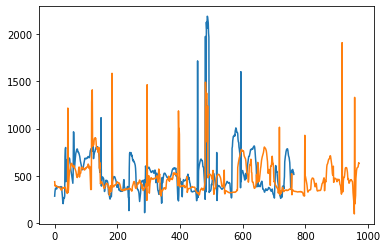

In [18]:
speak364 = np.array(native_english_speakers.at[364, 'f1'])
speak500 = np.array(native_english_speakers.at[500, 'f1'])
plt.plot(speak364)
plt.plot(speak500);

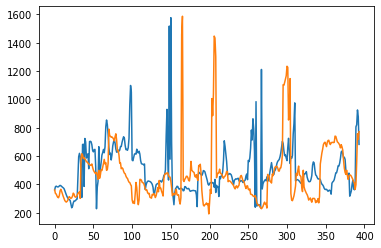

In [19]:
speak364_clip = np.array(native_english_speakers_clip.at[364, 'f1'])
speak500_clip = np.array(native_english_speakers_clip.at[500, 'f1'])
plt.plot(speak364_clip)
plt.plot(speak500_clip);

In [20]:
nes_men_clip.head()

,index,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3
0,363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.2182877031718, 383.30346835253516, 375.73...","[2146.2251420158764, 2265.0581423163667, 2239....","[2526.1644586236, 2580.1176437941363, 2610.888..."
4,367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.1779899620307, 396.38350482485237, 387.79...","[1172.0650517455977, 1237.7100570517323, 1354....","[2986.759301951157, 2949.6837478726425, 2712.7..."
5,368,21.0,0.0,"staten island, new york, usa",english103,english,male,66,usa,False,"[269.5861431948941, 340.4010965355361, 334.618...","[1205.9780100044734, 1397.2832730031703, 1567....","[2671.604922027467, 2668.797234114747, 2633.12..."
7,370,57.0,0.0,"windsor, ontario, canada",english105,english,male,407,canada,False,"[722.7066762392138, 489.36106049747855, 447.79...","[2472.697784017536, 1034.6829637259643, 1096.1...","[3744.9163882713224, 2656.652148500367, 2544.8..."
9,372,19.0,0.0,"chicago, illinois, usa",english107,english,male,416,usa,False,"[1197.231143755197, 1128.0643819940615, 530.12...","[2598.680493153703, 2558.291455196927, 1566.69...","[3476.2290816147097, 3852.316827455011, 3012.3..."


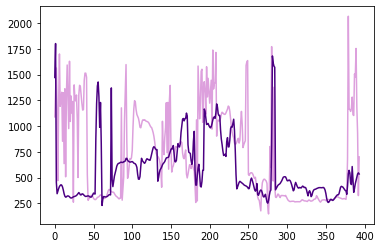

In [21]:
wom_speak366 = np.array(nes_wom_clip.at[366, 'f1'])
wom_speak367 = np.array(nes_wom_clip.at[367, 'f1'])
plt.plot(wom_speak366, 'plum')
plt.plot(wom_speak367, 'indigo')

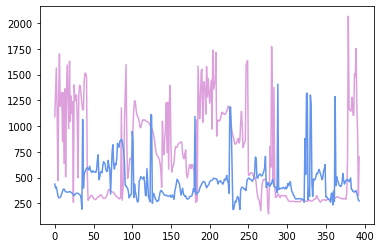

In [22]:
man_speak372 = np.array(nes_men_clip.at[372, 'f1'])
plt.plot(wom_speak366, color = 'plum')
plt.plot(man_speak372, color = 'cornflowerblue')

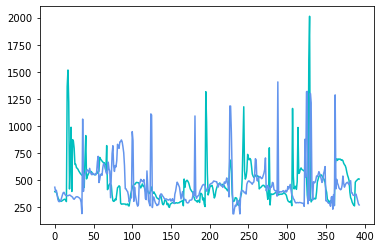

In [23]:
man_speak374 = np.array(nes_men_clip.at[4, 'f1'])
plt.plot(man_speak374, color = 'c')
plt.plot(man_speak372, color = 'cornflowerblue')

# Cross-Correlation - Donovan

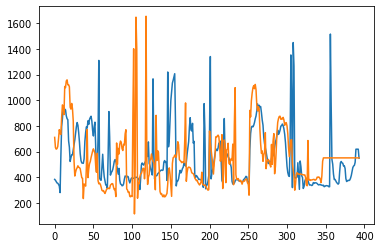

In [26]:
#Just some correlation testing
def patch_invalid(x):
  for i in range(1, len(x)):
    if math.isnan(x[i]):
      x[i] = x[i-1]
  return x

def resample_to_length(audio, length):
  audio = patch_invalid(audio)
  interp_domain = np.linspace(0, len(audio), length)
  return np.interp(interp_domain, np.arange(0, len(audio)), audio)

#returns the ideal shift to match the offset of file_a
def cross_corr(file_a, file_b):
  #largest allowed offset to shift the datapoints
  MAX_SHIFT = 50
  dat1_m = file_a - np.mean(file_a)
  dat2_m = file_b - np.mean(file_b)
  min_index = len(dat1_m) - MAX_SHIFT
  max_index = len(dat1_m) + MAX_SHIFT
  #find the maximum correlation from within (-MAX_SHIFT, +MAX_SHIFT)
  shift = np.argmax(np.correlate(dat1_m, dat2_m, mode='full')[min_index:max_index]) - MAX_SHIFT
  return shift

def apply_shift(audio, shift):
  audio = np.roll(audio, shift)
  if shift > 0:
    audio[0:shift] = np.mean(audio)
  else:
    audio[shift:] = np.mean(audio)
  
  return audio

AUDIO_LEN = 394

#grab the standard snippet to correlate the rest to:
ideal = native_english_speakers.iloc[0]
ideal_corr = resample_to_length(np.array(ideal.f1), AUDIO_LEN)

#compute adjusted dataframe
f1_corr, f2_corr, f3_corr = [], [], []
shifts = []
for i, row in native_english_speakers.iterrows():
  f1 = resample_to_length(np.array(row.f1), AUDIO_LEN)
  shift = cross_corr(ideal_corr, f1)
  shifts.append(shift)
  f1_corr.append(apply_shift(f1, shift))
  f2_corr.append(apply_shift(resample_to_length(row.f2, AUDIO_LEN), shift))
  f3_corr.append(apply_shift(resample_to_length(row.f3, AUDIO_LEN), shift))
  #print(f"applied shift of {shift} to row {i}")

english_corr = native_english_speakers.copy(deep=True)
english_corr['f1'] = f1_corr
english_corr['f2'] = f2_corr
english_corr['f3'] = f3_corr
plt.plot(english_corr.loc[363, 'f1'])
plt.plot(english_corr.loc[638, 'f1'])

In the above plot we can see that the shift aligns some of the major structures within the formant vector between two speakers.

In [27]:
cross_corr(man_speak372, man_speak374)

18

In [28]:
cross_corr(speak364_clip, speak500_clip) 

12

# Formant Mean Testing - Dong

In [29]:
native_english_speakers.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3
363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.21766592628603, 383.3048603159792, 375.73...","[2146.197420848668, 2265.073676608922, 2238.96...","[2526.155130504279, 2580.1540708955213, 2610.8..."
364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,"[285.791572791465, 333.5406503005196, 358.1649...","[1974.9033700266357, 2084.588564208539, 2124.4...","[2853.4023216197447, 2889.707512237676, 2857.9..."
365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,"[313.11571323002556, 293.7516378968984, 291.04...","[837.2749761154321, 998.0551739573779, 1028.83...","[1309.0288192622993, 1290.5245752384428, 1285...."
366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,"[428.3027180808342, 402.10113594759747, 443.54...","[1610.8220469527037, 1729.9302654331407, 1802....","[2926.824953545606, 3045.423389665372, 3216.60..."
367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.16943505125215, 396.30873727164476, 387.7...","[1172.411118682909, 1237.7783779601746, 1354.2...","[2986.2940891488297, 2949.1760833289895, 2712...."


In [30]:
def mean_df(df):
  mean_data = pd.DataFrame(columns=['f1', 'f2', 'f3'])

  for idx, rows in df.iterrows():
    f_1 = [x for x in rows['f1'] if np.isnan(x) == False]
    f_2 = [y for y in rows['f2'] if np.isnan(y) == False]
    f_3 = [z for z in rows['f3'] if np.isnan(z) == False]
    
    mean_1 = np.mean(f_1)
    mean_2 = np.mean(f_2)
    mean_3 = np.mean(f_3)

    mean_data.at[idx, 'f1'] = mean_1
    mean_data.at[idx, 'f2'] = mean_2
    mean_data.at[idx, 'f3'] = mean_3 

  return mean_data 

In [31]:
mean_data = mean_df(native_english_speakers)

mean_wom = mean_df(nes_wom_clip)
mean_men = mean_df(nes_men_clip)

mean_wom_usa = mean_df(nes_wom_clip_usa)
mean_men_usa = mean_df(nes_men_clip_usa)

In [32]:
mean_men.shape

(305, 3)

In [33]:
mean_men_usa.shape

(187, 3)

In [34]:
mean_data.shape

(579, 3)

In [35]:
#getting rid some of the outliers
f12_df = mean_data[['f1', 'f2']]

In [36]:
f12_df_men = mean_men[['f1', 'f2']]
f12_df_wom = mean_wom[['f1', 'f2']]

f12_df_men_usa = mean_men_usa[['f1', 'f2']]
f12_df_wom_usaa = mean_wom_usa[['f1', 'f2']]

In [37]:
f12_df = f12_df[(f12_df['f1'] <= 1250) & (f12_df['f2'] <= 2350)]
f12_df.max()

f1    1248.410638
f2    2276.193613
dtype: object

In [38]:
mean_data.head()

,f1,f2,f3
363,547.496854,1709.046391,2663.696484
364,530.511878,1803.605822,2749.313185
365,384.03308,1692.323742,2972.540686
366,497.698778,1887.704375,2951.700385
367,448.085294,1463.736703,2649.212007


Gonna visualize the f1, f2, and f3

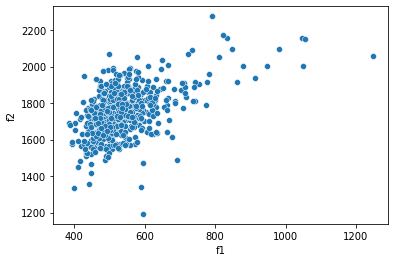

In [39]:
# F1 and F2
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df)

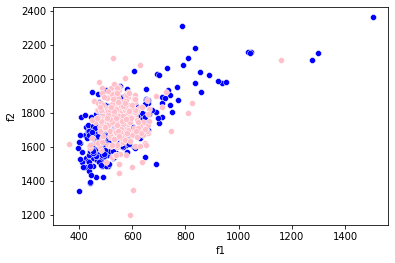

In [40]:
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df_men, color = 'blue')
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df_wom, color = 'pink');

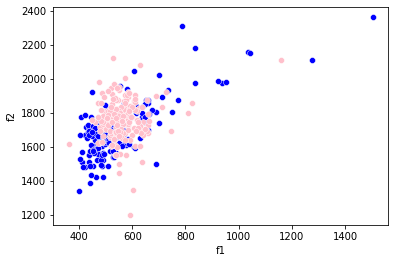

In [41]:
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df_men_usa, color = 'blue')
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df_wom_usaa, color = 'pink');

# PCA - Donovan


(575, 1182)


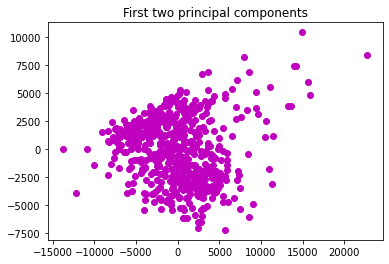

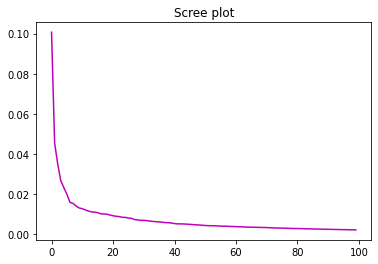

In [42]:
#wrangling nonsense to get dataframe into a numpy array
#each formant is concatenated together into the same column
def PCA_plot(df, color = 'm'): 
  selectf1 = df[['f1']]
  selectf2 = df[['f2']]
  selectf3 = df[['f3']]
  npself1 = selectf1.to_numpy().reshape((len(selectf1),))
  npself1_2d = np.array(list(npself1))
  npself2 = selectf2.to_numpy().reshape((len(selectf2),))
  npself2_2d = np.array(list(npself2))
  npself3 = selectf3.to_numpy().reshape((len(selectf3),))
  npself3_2d = np.array(list(npself3))
  total_np_data = np.concatenate((npself1_2d, npself2_2d, npself3_2d), axis=1)

  #remove a handful of nan/inf
  total_np_data[~np.isfinite(total_np_data)] = 0
  print(total_np_data.shape)


  pca_var = PCA(n_components=100)
  pca_df = pca_var.fit_transform(total_np_data)
  plt.title("First two principal components")
  plt.scatter(pca_df[:,0], pca_df[:,1], color = color)
  plt.figure(color)
  plt.title("Scree plot")
  plt.plot(pca_var.explained_variance_ratio_, color)

  return pca_df

pca_df  = PCA_plot(native_english_speakers_clip)


#TODO: Use regions for coloring points in the plot, see if there is some structure

(305, 1182)


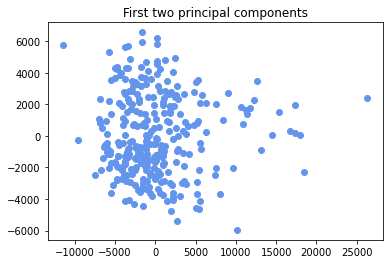

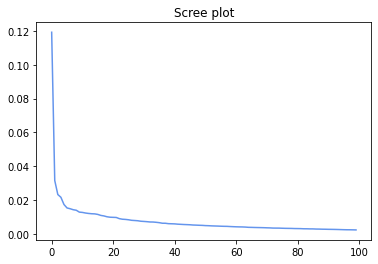

In [43]:
pca_df_men = PCA_plot(nes_men_clip, 'cornflowerblue')

(270, 1182)


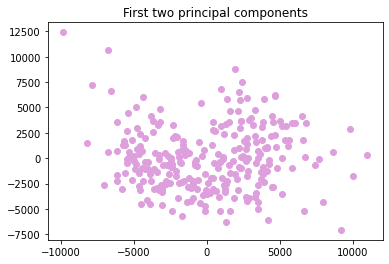

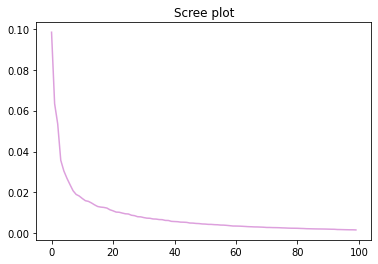

In [44]:
pca_df_wom = PCA_plot(nes_wom_clip, 'plum')

(187, 1182)


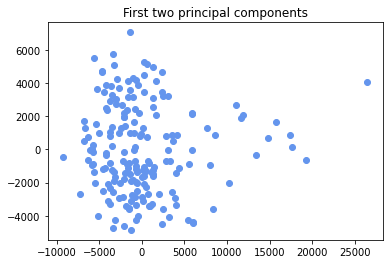

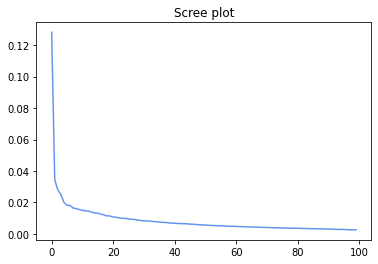

In [45]:
pca_df_men_usa = PCA_plot(nes_men_clip_usa, 'cornflowerblue')

(184, 1182)


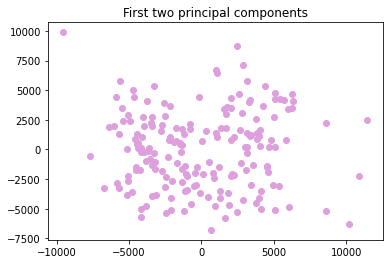

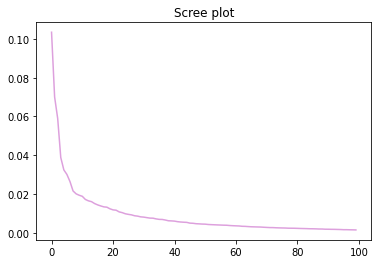

In [46]:
pca_df_wom_usa = PCA_plot(nes_wom_clip_usa, 'plum')

# K-Means - Aryaman


In [47]:
colors = ['crimson', 'deeppink', 'palevioletred', 'lightpink', 'mediumpurple', 'rebeccapurple', 'plum', 'mediumturquoise', 'thistle', 'firebrick', 'mediumslateblue', 'lightcoral', 'orchid']
m_col = ['mediumturquoise', 'thistle', 'firebrick', 'mediumslateblue', 'lightcoral', 'orchid', 'teal', 'dodgerblue', 'aquamarine', 'navy', 'goldenrod', 'olivedrab', 'paleturquoise', 'seagreen']
w_col = ['plum', 'm', 'deeppink', 'crimson', 'darkviolet', 'darkslateblue', 'slateblue', 'blueviolet', 'crimson', 'deeppink', 'palevioletred', 'lightpink', 'mediumpurple', 'rebeccapurple', 'cornflowerblue' ]

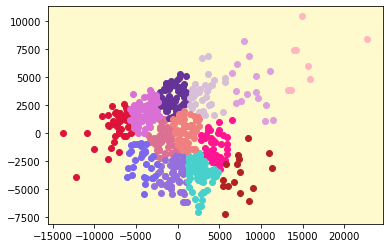

In [48]:
#Using first 2 principal components
def kmeans(df, colors, n_clusters): 
  component_1 = df[:,0]
  component_2 = df[:,1]
  X = [[component_1[i], component_2[i]] for i in range(len(component_1))]
  kmeans = KMeans(n_clusters).fit(X)
  kmeans_df = pd.DataFrame({'component_1' : component_1, 'component_2' : component_2, 'cluster_assignment': kmeans.labels_})
  plt.rcParams.update({'axes.facecolor':'lemonchiffon'})
  plt.rcParams.update({'text.color' : "cornflowerblue",'axes.labelcolor' : "cornflowerblue"})
  plt.figure(facecolor='white') 

  for i in range(n_clusters): 
    plt.scatter(kmeans_df.loc[kmeans_df.cluster_assignment == i].iloc[:,0] , kmeans_df.loc[kmeans_df.cluster_assignment == i].iloc[:, 1] , color = colors[i])

  plt.show()
  return kmeans_df

kmeans_df = kmeans(pca_df, colors, 13)

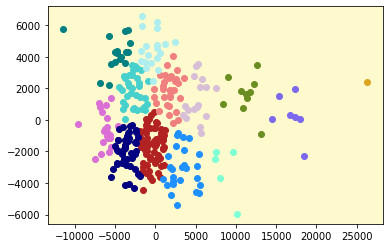

In [49]:
kmeans_df_men = kmeans(pca_df_men, m_col, 13)

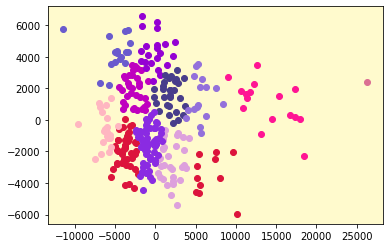

In [50]:
kmeans_df_wom = kmeans(pca_df_men, w_col,13)

In [51]:
kmeans_df.cluster_assignment.value_counts()

12    84
5     66
7     66
11    64
2     53
4     53
1     46
0     41
8     33
10    30
9     16
6     15
3      8
Name: cluster_assignment, dtype: int64

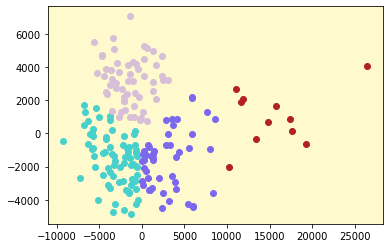

In [52]:
kmeans_df_men_usa = kmeans(pca_df_men_usa, m_col, 4)

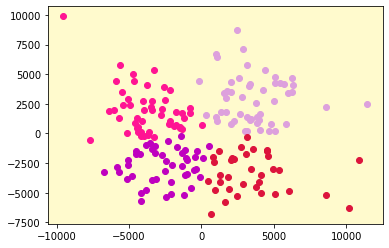

In [53]:
kmeans_df_wom_usa = kmeans(pca_df_wom_usa, w_col, 4)

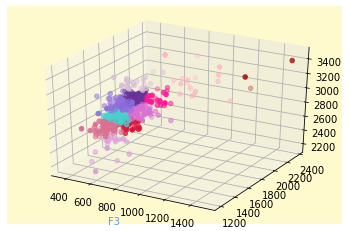

In [54]:
def kmeans3d(df, colors, n_clusters): 
  f1_means = df['f1'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  f2_means = df['f2'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  f3_means = df['f3'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  X = [[f1_means[i], f2_means[i], f3_means[i]] for i in range(len(f1_means))]
  
  kmeans_3d = KMeans(n_clusters).fit(X)
  temp_df = pd.DataFrame({'f1_means': f1_means, 'f2_means': f2_means, 'f3_means': f3_means, 'cluster': kmeans_3d.labels_})
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  for i in range(0,n_clusters): 
    ax.scatter(temp_df.loc[temp_df.cluster == i].iloc[:, 0], temp_df.loc[temp_df.cluster == i].iloc[:, 1], temp_df.loc[temp_df.cluster == i].iloc[:, 2], color = colors[i])

  ax.set_xlabel('F1')
  ax.set_xlabel('F2')
  ax.set_xlabel('F3')
  plt.show()
  return temp_df

temp_df = kmeans3d(native_english_speakers_clip, colors, 13)

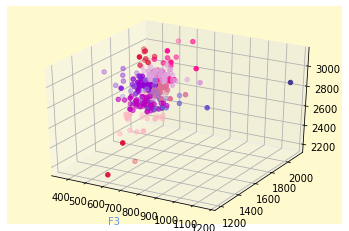

In [55]:
kmeans3d(nes_wom_clip, w_col, 13);

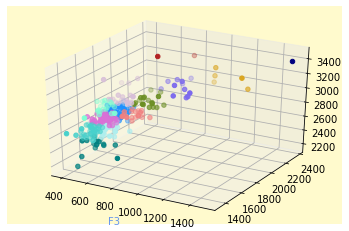

In [56]:
kmeans3d(nes_men_clip, m_col, 13);

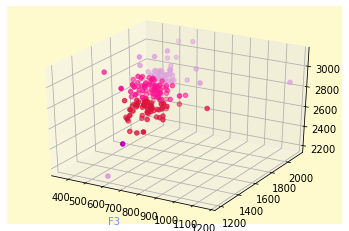

In [57]:
kmeans3d(nes_wom_clip_usa, w_col, 4);

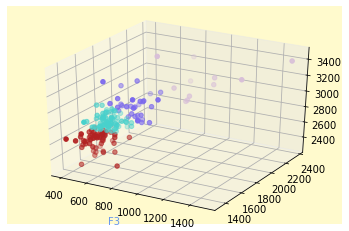

In [58]:
kmeans3d(nes_men_clip_usa, m_col, 4);

In [59]:
temp_df.cluster.value_counts()

7     79
0     74
10    70
2     69
5     66
12    47
4     43
11    42
1     23
8     22
6     20
3     17
9      3
Name: cluster, dtype: int64

# GHMM - Dong


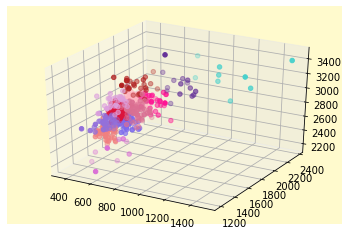

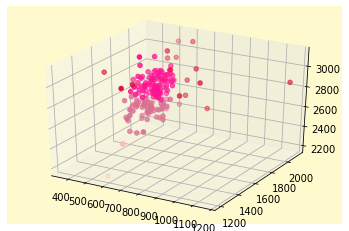

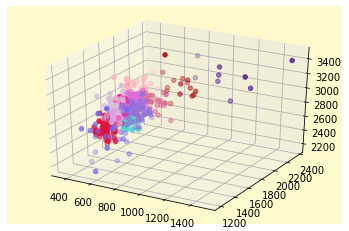

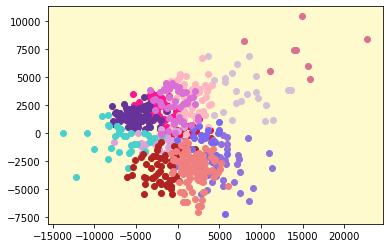

In [60]:
from librosa.core.notation import thaat_to_degrees
# how many clusters do we want to be dtermined later
# focusing on f1, f2, f3 I am assuming but right now using the f1 and f2 to get used of using the HMM

def GHMM(nes, pca_df, clusters, threeD = False, colors = colors): 
  comp_1 = pca_df[:,0]
  comp_2 = pca_df[:,1]

  f1_means = nes['f1'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  f2_means = nes['f2'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  f3_means = nes['f3'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  pca_com_12 = [[comp_1[i], comp_2[i]] for i in range(len(comp_1))]

  model = hmm.GaussianHMM(n_components= clusters)
  PCA_HMM = model.fit(pca_com_12)
  hidden_states = PCA_HMM.predict(pca_com_12)
  model2 = hmm.GaussianHMM(n_components= clusters)
  X = [[f1_means[i], f2_means[i], f3_means[i]] for i in range(len(f1_means))]
  mean_HMM = model2.fit(X)
  states = mean_HMM.predict(X)
  HMM_df = pd.DataFrame({'component_1' : comp_1, 'component_2' : comp_2, 'cluster_assignment': hidden_states})

  HMM3D_df = pd.DataFrame({'f1' : f1_means, 'f2' : f2_means, 'f3' : f3_means, 'cluster': states})
  fig2 = plt.figure()
  kx = fig2.add_subplot(projection='3d')


  for i in range(clusters):
    kx.scatter(HMM3D_df.loc[HMM3D_df.cluster == i].iloc[:, 0], HMM3D_df.loc[HMM3D_df.cluster == i].iloc[:, 1], HMM3D_df.loc[HMM3D_df.cluster == i].iloc[:, 2], color = colors[i])
  plt.show()
  # display(fig2)

  if threeD: 
    return HMM3D_df

  if not threeD: 
    return HMM_df

HMM3D_df = GHMM(native_english_speakers_clip, pca_df, 13, threeD = True)
HMM3D_df_wom = GHMM(nes_wom_clip_usa, pca_df, 4, threeD = True)
GHMM3d_df = GHMM(native_english_speakers_clip, pca_df, 13, threeD = False)
GHMM3d_df.cluster_assignment.value_counts()

clusters = 13
for i in range(clusters):
  plt.scatter(GHMM3d_df.loc[GHMM3d_df.cluster_assignment == i].iloc[:, 0] , GHMM3d_df.loc[GHMM3d_df.cluster_assignment == i].iloc[:, 1], color = colors[i])

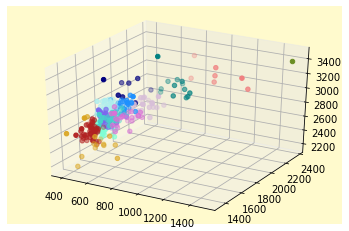

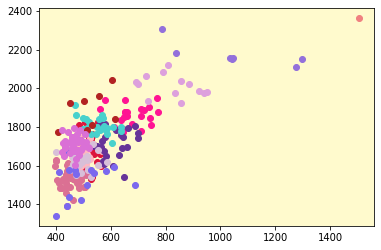

In [61]:
GHMM3d_df_men = GHMM(nes_men_clip, pca_df_men, 13, threeD = True, colors = m_col)
GHMM3d_df_men.cluster.value_counts()
for i in range(clusters):
  plt.scatter(GHMM3d_df_men.loc[GHMM3d_df_men.cluster == i].iloc[:, 0] , GHMM3d_df_men.loc[GHMM3d_df_men.cluster == i].iloc[:, 1], color = colors[i])

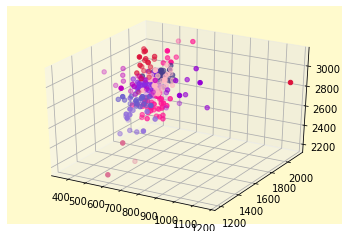

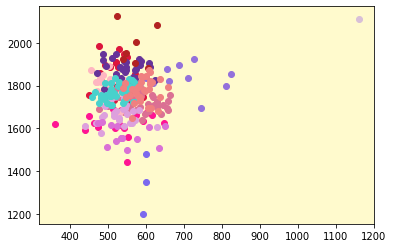

In [62]:
GHMM3d_df_wom = GHMM(nes_wom_clip, pca_df_wom, 13, threeD = True, colors = w_col)
GHMM3d_df_wom.cluster.value_counts()

for i in range(clusters):
  plt.scatter(GHMM3d_df_wom.loc[GHMM3d_df_wom.cluster == i].iloc[:, 0] , GHMM3d_df_wom.loc[GHMM3d_df_wom.cluster == i].iloc[:, 1], color = colors[i])

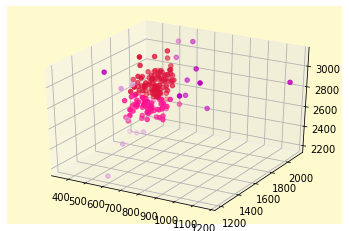

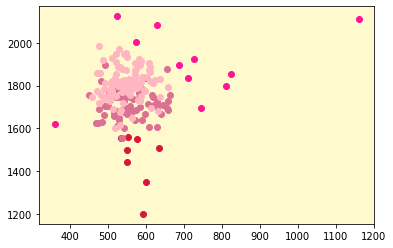

In [63]:
GHMM3d_df_wom_usa = GHMM(nes_wom_clip_usa, pca_df_wom_usa, 4, threeD=True, colors = w_col)
GHMM3d_df_wom_usa.cluster.value_counts()


clusters = 4
for i in range(clusters):
  plt.scatter(GHMM3d_df_wom_usa.loc[GHMM3d_df_wom_usa.cluster == i].iloc[:, 0] , GHMM3d_df_wom_usa.loc[GHMM3d_df_wom_usa.cluster == i].iloc[:, 1], color = colors[i])

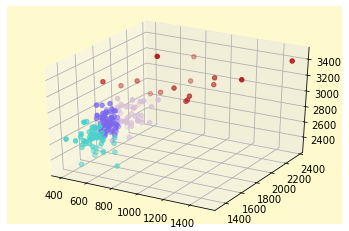

187


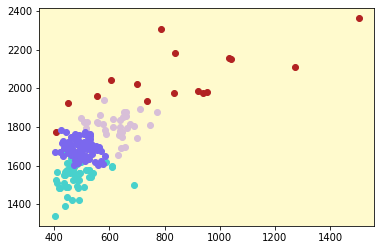

In [64]:
GHMM3d_df_men_usa = GHMM(nes_men_clip_usa, pca_df_men_usa, 4, threeD=True, colors = m_col)
GHMM3d_df_men_usa.cluster.value_counts()

print(GHMM3d_df_men_usa.cluster.size)

clusters = 4
for i in range(clusters):
  plt.scatter(GHMM3d_df_men_usa.loc[GHMM3d_df_men_usa.cluster == i].iloc[:, 0] , GHMM3d_df_men_usa.loc[GHMM3d_df_men_usa.cluster == i].iloc[:, 1], color = m_col[i])

In [65]:
# HMM3D_df = pd.DataFrame({'f1' : mean_data.f1.values.tolist(), 'f2' : mean_data.f2.values.tolist(), 'f3' : mean_data.f2.values.tolist(), 'cluster': states})
f1_means = native_english_speakers_clip['f1'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
f2_means = native_english_speakers_clip['f2'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
f3_means = native_english_speakers_clip['f3'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()

# Accuracy Testing - John

We start by assigning each speaker in the original dataframe their cluster. Later we'll test if each cluster actually sorted the speakers according to region in a statistically meaningful way through chi-squared goodness of fit analysis.

In [66]:
new_speaker_df = native_english_speakers_clip.reset_index()

new_speaker_df['cluster'] = HMM3D_df['cluster']
new_speaker_df

,level_0,index,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3,cluster
0,0,363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.2182877031718, 383.30346835253516, 375.73...","[2146.2251420158764, 2265.0581423163667, 2239....","[2526.1644586236, 2580.1176437941363, 2610.888...",10
1,1,364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,"[285.78034366393695, 333.54027986877463, 358.2...","[1974.7398866094045, 2084.5578055165697, 2124....","[2853.2928088694052, 2889.6240622315777, 2857....",10
2,2,365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,"[312.9781514843358, 293.60305965141947, 290.88...","[837.3376620186896, 993.2380910061022, 1023.86...","[1309.120766111249, 1290.5791719544743, 1285.8...",6
3,3,366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,"[428.3056496833393, 402.106152536091, 443.5521...","[1610.8457576851163, 1730.00458789682, 1802.83...","[2926.867159255761, 3045.4127116240597, 3216.4...",6
4,4,367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.1779899620307, 396.38350482485237, 387.79...","[1172.0650517455977, 1237.7100570517323, 1354....","[2986.759301951157, 2949.6837478726425, 2712.7...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,570,937,18.0,0.0,"mishawaka, indiana, usa",english95,english,male,160,usa,False,"[225.37493141298384, 429.2322347330008, 391.57...","[1156.3249709505758, 1244.426330722122, 1320.0...","[2508.9895440671307, 2484.205074689459, 2496.1...",4
571,571,938,31.0,0.0,"point pleasant, new jersey, usa",english96,english,male,161,usa,False,"[387.73587571581527, 294.2607926137612, 332.01...","[1685.3000465157481, 1670.8185592715527, 1705....","[2941.646285834069, 2376.5823506980514, 2429.0...",0
572,572,939,42.0,0.0,"wilmington nc, north carolina, usa",english97,english,male,162,usa,False,"[1233.2597285111324, 1676.7783128168037, 1601....","[2203.0919270175045, 1963.970939316393, 1760.4...","[3265.9801038036912, 2595.619642668225, 2386.0...",7
573,573,940,22.0,0.0,"spokane, washington, usa",english98,english,male,163,usa,False,"[290.1602083589574, 301.000151798266, 299.4749...","[1263.876121389454, 1295.0817944345456, 1370.1...","[2635.912026875992, 2791.161318002734, 2724.55...",11


In [67]:
#Making sure hmm3d_df means align with native_english_speakers so we can start cross referencing
speaker_1_f1 = new_speaker_df.iloc[0]['f1']
speaker_1_f1 = [x for x in speaker_1_f1 if np.isnan(x) == False]
np.mean(speaker_1_f1)

563.3245301929626

In [68]:
#Time to generalize locations
the_west = ["washington", "oregon", "california", "idaho", "utah", "montana", "colorado", "nevada", "arizona", "new mexico", "alaska", "hawaii", "wyoming"] 
the_midwest =  ["north dakota", "south dakota", "nebraska", "kansas",  "wisconsin", "minnesota", "illinois", "missouri", "indiana", "michigan", "iowa", "ohio", "pennsylvania"] 
the_south = ["west virginia", "kentucky", "oklahoma", "texas", "tennessee", "mississippi", "georgia", "alabama", "arkansas", "florida", "south carolina", "north carolina", "louisiana"] 
the_north = ['va', "new york", "maryland", "delaware", "virginia", "maine", "new hampshire", "vermont", "massachusetts", "rhode island", "connecticut", "new jersey"]

the_carribbean = ['us virgin islands', 'jamaica', 'barbados', 'the bahamas', 'antigua and barbuda', 'trinidad']
south_pacific = ['fiji', 'malaysia', 'philippines', 'singapore'] 
c_and_south_america = ['guyana', 'panama', 'belize', 'bolivia'] 
west_africa = ['liberia', 'nigeria', 'ghana']
uk = ['uk', 'isle of man', 'ireland']
germanic_europe = ['germany', 'switzerland']
romantic_europe = ['italy', 'spain']
m_east = ['lebanon', 'united arab emirates', 'pakistan', ] 
oceania = ['australia', 'new zealand', 'papua new guinea']

def regionalize(df): 
  region = []
  for strng in df['birthplace']:
    strng_country = str(strng.split(',')[-1]).strip()

    if strng_country == 'usa': 
      # region.append('US')
      if any(state in strng for state in the_north) or strng_country == 'virginia':
        region.append('the_north')
      elif any(state in strng for state in the_west):
        region.append('the_west')
      elif any(state in strng for state in the_midwest):
        region.append('the_midwest')
      elif any(state in strng for state in the_south):
        region.append('the_south')
      else:
        region.append('no_assignment')
        print(strng)

    else: 
      if strng_country == 'canada':
        region.append('Canada')
      elif strng_country in the_carribbean:
        region.append('Caribbean')
      elif strng_country in south_pacific:
        region.append('South Pacific')
      elif strng_country in c_and_south_america:
        region.append('Central or South America')
      elif strng_country in west_africa:
        region.append('West Africa')
      elif strng_country in uk:
        region.append('UK')
      elif strng_country in germanic_europe:
        region.append('Germanic Europe')
      elif strng_country in romantic_europe:
        region.append('Romantic Europe')
      elif strng_country in m_east:
        region.append('Middle East')
      elif strng_country in oceania:
        region.append('Oceania')
      elif strng_country == 'india':
        region.append('India')
      elif strng_country == 'south africa':
        region.append('South Africa')
      else:
        region.append('no assignment')
        # print(strng_country)

  df['region'] = region
  return df

new_speaker_df = regionalize(new_speaker_df)
new_speaker_df.head()

,level_0,index,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3,cluster,region
0,0,363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.2182877031718, 383.30346835253516, 375.73...","[2146.2251420158764, 2265.0581423163667, 2239....","[2526.1644586236, 2580.1176437941363, 2610.888...",10,the_north
1,1,364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,"[285.78034366393695, 333.54027986877463, 358.2...","[1974.7398866094045, 2084.5578055165697, 2124....","[2853.2928088694052, 2889.6240622315777, 2857....",10,the_midwest
2,2,365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,"[312.9781514843358, 293.60305965141947, 290.88...","[837.3376620186896, 993.2380910061022, 1023.86...","[1309.120766111249, 1290.5791719544743, 1285.8...",6,the_south
3,3,366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,"[428.3056496833393, 402.106152536091, 443.5521...","[1610.8457576851163, 1730.00458789682, 1802.83...","[2926.867159255761, 3045.4127116240597, 3216.4...",6,Canada
4,4,367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.1779899620307, 396.38350482485237, 387.79...","[1172.0650517455977, 1237.7100570517323, 1354....","[2986.759301951157, 2949.6837478726425, 2712.7...",4,the_north


In [69]:
new_wom_df = nes_wom_clip.reset_index()
new_wom_df['cluster'] = HMM3D_df['cluster']

In [70]:
new_men_df = nes_wom_clip.reset_index()
new_men_df = native_english_speakers_clip.reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(184, 1182)


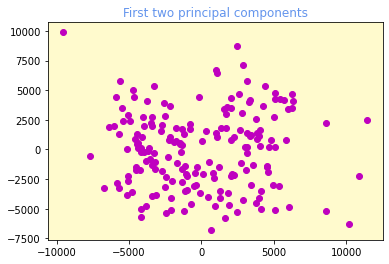

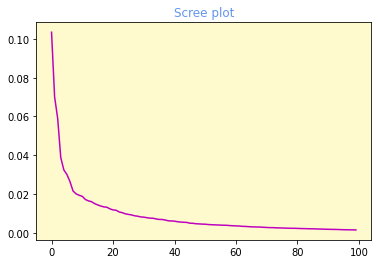

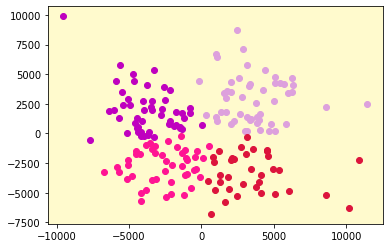

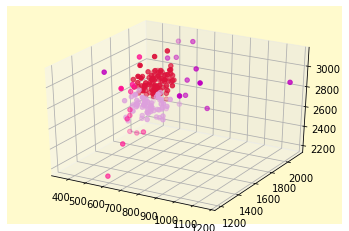

the_midwest     7
the_west        6
the_south       5
UK              4
the_north       3
Oceania         2
South Africa    1
Name: region, dtype: int64

In [71]:
nes_wom_clip_usa_df = regionalize(nes_wom_clip_usa)
nes_wom_clip_usa_df.head()
a = kmeans(PCA_plot(nes_wom_clip_usa_df), w_col, 4)
nes_wom_clip_usa_dfa = nes_wom_clip_usa_df.reset_index()

nes_wom_clip_usa_dfa['cluster'] = HMM3D_df_wom['cluster']
nes_wom_clip_usa_dfa

GHMM3d_df_wom_usa = GHMM(nes_wom_clip_usa, pca_df_wom_usa, 4, threeD=True, colors = w_col)
new_speaker_df[new_speaker_df['cluster'] == 1]['region'].value_counts()


In [72]:
new_speaker_df[new_speaker_df['cluster'] == 1]['region'].value_counts()

the_midwest     7
the_west        6
the_south       5
UK              4
the_north       3
Oceania         2
South Africa    1
Name: region, dtype: int64

In [73]:
new_speaker_df[new_speaker_df['cluster'] == 2]['region'].value_counts()

the_north        19
the_south        12
the_midwest      12
UK                5
Oceania           5
the_west          4
Caribbean         2
South Pacific     1
Canada            1
Middle East       1
Name: region, dtype: int64

In [74]:
new_speaker_df[new_speaker_df['cluster'] == 3]['region'].value_counts()

UK               15
the_north        14
the_west         14
the_midwest       7
the_south         7
Canada            6
Oceania           6
Caribbean         3
South Pacific     2
West Africa       1
Name: region, dtype: int64

In [75]:
new_speaker_df[new_speaker_df['cluster'] == 4]['region'].value_counts()

the_north          13
the_midwest         8
the_south           8
UK                  6
Canada              3
the_west            3
Oceania             2
South Pacific       1
no assignment       1
South Africa        1
Germanic Europe     1
Romantic Europe     1
Name: region, dtype: int64

In [76]:
nes_men_clip_usa_df = regionalize(nes_men_clip_usa)
nes_men_clip_usa_df['cluster'] = GHMM3d_df_men_usa['cluster']
nes_men_clip_usa_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3,region,cluster
0,363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.2182877031718, 383.30346835253516, 375.73...","[2146.2251420158764, 2265.0581423163667, 2239....","[2526.1644586236, 2580.1176437941363, 2610.888...",the_north,3.0
4,367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.1779899620307, 396.38350482485237, 387.79...","[1172.0650517455977, 1237.7100570517323, 1354....","[2986.759301951157, 2949.6837478726425, 2712.7...",the_north,1.0
5,368,21.0,0.0,"staten island, new york, usa",english103,english,male,66,usa,False,"[269.5861431948941, 340.4010965355361, 334.618...","[1205.9780100044734, 1397.2832730031703, 1567....","[2671.604922027467, 2668.797234114747, 2633.12...",the_north,3.0
9,372,19.0,0.0,"chicago, illinois, usa",english107,english,male,416,usa,False,"[1197.231143755197, 1128.0643819940615, 530.12...","[2598.680493153703, 2558.291455196927, 1566.69...","[3476.2290816147097, 3852.316827455011, 3012.3...",the_midwest,3.0
19,382,56.0,0.0,"atlanta, georgia, usa",english116,english,male,444,usa,False,"[740.5617744291447, 802.5377822447599, 912.037...","[2736.9096860037084, 2757.5398531388814, 2726....","[3745.376030279645, 3767.138352852434, 3776.75...",the_south,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,932,53.0,0.0,"pittsburgh, pennsylvania, usa",english90,english,male,155,usa,False,"[393.1553164364345, 402.8380634935432, 399.174...","[1685.2713887897069, 1754.3672215154597, 1834....","[2413.6528759328617, 2396.016307426744, 2377.0...",the_north,NaN
570,937,18.0,0.0,"mishawaka, indiana, usa",english95,english,male,160,usa,False,"[225.37493141298384, 429.2322347330008, 391.57...","[1156.3249709505758, 1244.426330722122, 1320.0...","[2508.9895440671307, 2484.205074689459, 2496.1...",the_midwest,NaN
571,938,31.0,0.0,"point pleasant, new jersey, usa",english96,english,male,161,usa,False,"[387.73587571581527, 294.2607926137612, 332.01...","[1685.3000465157481, 1670.8185592715527, 1705....","[2941.646285834069, 2376.5823506980514, 2429.0...",the_north,NaN
572,939,42.0,0.0,"wilmington nc, north carolina, usa",english97,english,male,162,usa,False,"[1233.2597285111324, 1676.7783128168037, 1601....","[2203.0919270175045, 1963.970939316393, 1760.4...","[3265.9801038036912, 2595.619642668225, 2386.0...",the_south,NaN


In [77]:
nes_men_clip_usa_df['cluster'].eq(2).astype(int).groupby(nes_men_clip_usa_df['region']).sum()

region
the_midwest    0
the_north      2
the_south      1
the_west       1
Name: cluster, dtype: int64

In [78]:
nes_men_clip_usa_df['region'].value_counts(normalize=True)

the_north      0.401070
the_midwest    0.229947
the_south      0.208556
the_west       0.160428
Name: region, dtype: float64

In [79]:
#The region distributions of each cluster resemble our total counts so let's run a chi-square test for each cluster and see if each cluster just reflects our population
import scipy.stats as stats
def chi_square(df, order_fit, num_clusters):
  init_list = df['region'].value_counts(normalize=True).tolist()
  multipliers = [init_list[i] for i in order_fit]

  critical_value = stats.chi2.ppf(q=0.95, df=num_clusters-1)
  print("Critical value: " + str(critical_value) + "\n")

  for i in range(num_clusters):
    print("Cluster " + str(i) + ":")
    observed_frequencies = df['cluster'].eq(i).astype(int).groupby(df['region']).sum().tolist()
    expected_frequencies = [value * int(df['cluster'].value_counts()[i]) for value in multipliers]
    print(stats.chisquare(f_obs = observed_frequencies, f_exp = expected_frequencies))
    print('')
    

In [80]:
#Ignore, manually adjusting the expected array to fit the arbitrary order given by .sum() of observed
#for new_speaker_df
fitted_order = [5,7,9,14,11,13,6,15,10,8,3,12,16,1,0,2,4]
#for nes_wom_clip_usa_dfa
fitted_order_wom = [1,0,2,3]
#for nes_men_clip_usa_df
fitted_order_men = [1,0,2,3]

In [81]:
#Testing GHMM 13 cluster approach
chi_square(new_speaker_df,fitted_order,13)

Critical value: 21.02606981748307

Cluster 0:
Power_divergenceResult(statistic=14.246492274344517, pvalue=0.5803564000066421)

Cluster 1:
Power_divergenceResult(statistic=14.96902557137165, pvalue=0.5269083132436821)

Cluster 2:
Power_divergenceResult(statistic=12.65009965708355, pvalue=0.6981484102534665)

Cluster 3:
Power_divergenceResult(statistic=18.01551297891077, pvalue=0.3229893375616626)

Cluster 4:
Power_divergenceResult(statistic=23.957491057205562, pvalue=0.09043705859070589)

Cluster 5:
Power_divergenceResult(statistic=7.105409313064804, pvalue=0.9711754180452575)

Cluster 6:
Power_divergenceResult(statistic=27.82300022878215, pvalue=0.03319330990785822)

Cluster 7:
Power_divergenceResult(statistic=11.176418962089878, pvalue=0.7984671430626421)

Cluster 8:
Power_divergenceResult(statistic=24.904881801665404, pvalue=0.07151994421569166)

Cluster 9:
Power_divergenceResult(statistic=22.671957878912565, pvalue=0.12278919273286283)

Cluster 10:
Power_divergenceResult(statistic=1

In [82]:
#Testing GHMM USA women
chi_square(nes_wom_clip_usa_dfa, fitted_order_wom, 4)

Critical value: 7.814727903251179

Cluster 0:
Power_divergenceResult(statistic=1.3419505086355623, pvalue=0.7191964295339075)

Cluster 1:
Power_divergenceResult(statistic=1.5430828128864322, pvalue=0.6723631237775776)

Cluster 2:
Power_divergenceResult(statistic=2.9957156709991972, pvalue=0.3922862073170986)

Cluster 3:
Power_divergenceResult(statistic=2.3300110741971203, pvalue=0.5067959747157496)



In [83]:
#Testing GHMM USA men
chi_square(nes_men_clip_usa_df, fitted_order_men, 4)

Critical value: 7.814727903251179

Cluster 0:
Power_divergenceResult(statistic=0.7080381633870007, pvalue=0.8713116830833941)

Cluster 1:
Power_divergenceResult(statistic=1.4185330948121642, pvalue=0.701196279087352)

Cluster 2:
Power_divergenceResult(statistic=1.2503846153846152, pvalue=0.7409470662731727)

Cluster 3:
Power_divergenceResult(statistic=3.5104313257801634, pvalue=0.3194117308222879)



In [84]:
kmeans_df_men_usa['region'] = nes_men_clip_usa_df['region'].reset_index()['region']
kmeans_df_wom_usa['region'] = nes_wom_clip_usa_df['region'].reset_index()['region']
kmeans_df['region'] = new_speaker_df['region']

In [85]:
#Testing Kmeans
kmeans_df['cluster'] = kmeans_df['cluster_assignment']
chi_square(kmeans_df, fitted_order, 13)

Critical value: 21.02606981748307

Cluster 0:
Power_divergenceResult(statistic=9.451327067718493, pvalue=0.8936701961270322)

Cluster 1:
Power_divergenceResult(statistic=26.63572694529847, pvalue=0.045713874711232706)

Cluster 2:
Power_divergenceResult(statistic=6.840510690252131, pvalue=0.9762140184944241)

Cluster 3:
Power_divergenceResult(statistic=18.776517982119074, pvalue=0.2804224327336256)

Cluster 4:
Power_divergenceResult(statistic=8.898987091488634, pvalue=0.9175149679577509)

Cluster 5:
Power_divergenceResult(statistic=20.52228832804695, pvalue=0.19761225503856908)

Cluster 6:
Power_divergenceResult(statistic=4.903520593774259, pvalue=0.9962124103646358)

Cluster 7:
Power_divergenceResult(statistic=33.408871059452174, pvalue=0.006520689025989979)

Cluster 8:
Power_divergenceResult(statistic=7.9086931314976665, pvalue=0.9515381918973976)

Cluster 9:
Power_divergenceResult(statistic=19.942617092048987, pvalue=0.2228162805012053)

Cluster 10:
Power_divergenceResult(statistic=3

In [86]:
#Testing Kmeans USA men
kmeans_df_men_usa['cluster'] = kmeans_df_men_usa['cluster_assignment']
chi_square(kmeans_df_men_usa, fitted_order_men, 4)

Critical value: 7.814727903251179

Cluster 0:
Power_divergenceResult(statistic=1.7564705585930604, pvalue=0.6244529227575775)

Cluster 1:
Power_divergenceResult(statistic=2.624595578839765, pvalue=0.45319393101007777)

Cluster 2:
Power_divergenceResult(statistic=10.76304114490161, pvalue=0.013078697997633134)

Cluster 3:
Power_divergenceResult(statistic=1.9224942499361102, pvalue=0.5886480925064697)



In [87]:
#Testing Kmeans USA women
kmeans_df_wom_usa['cluster'] = kmeans_df_wom_usa['cluster_assignment']
chi_square(kmeans_df_wom_usa, fitted_order_wom, 4)

Critical value: 7.814727903251179

Cluster 0:
Power_divergenceResult(statistic=4.025170693727972, pvalue=0.2587589459189262)

Cluster 1:
Power_divergenceResult(statistic=6.581561356725736, pvalue=0.08650083054719074)

Cluster 2:
Power_divergenceResult(statistic=1.5021971426288765, pvalue=0.6817633238774521)

Cluster 3:
Power_divergenceResult(statistic=5.933349467152036, pvalue=0.1148983303622527)

